In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch

In [19]:
image = cv2.imread('test_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [3]:
from narya.utils.vizualization import visualize

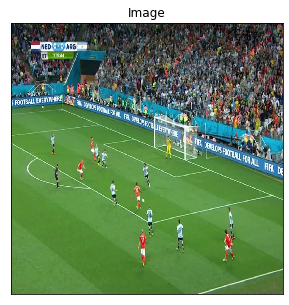

In [4]:
visualize(image=image)

In [5]:
from narya.models.keras_models import DeepHomoModel
from narya.models.keras_models import KeypointDetectorModel
from narya.models.gluon_models import TrackerModel
from narya.models.torch_models import ReIdModel

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [6]:
import tensorflow as tf
from narya.utils.homography import compute_homography, warp_image,warp_point
from narya.utils.image import torch_img_to_np_img, np_img_to_torch_img, denormalize
from narya.utils.utils import to_torch

In [8]:
template = cv2.imread('world_cup_template.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))
template = template/255.

# Deep Homo Prediction : 

In [7]:
full_model = DeepHomoModel()

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/deep_homo_model.h5"
)
RESNET_ARCHI_TF_KERAS_NAME = "deep_homo_model.h5"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/deep_homo_model.h5


In [9]:
corners = full_model(image)
pred_homo = compute_homography(corners)[0]
print(pred_homo)

[[ 3.3973143e-01 -1.2927253e-03  4.6077079e-01]
 [ 3.0281174e-01  1.7163661e+00  4.9089849e-02]
 [ 4.1546736e-02  1.5496995e+00  1.0000000e+00]]


In [10]:
pred_warp = warp_image(np_img_to_torch_img(template),to_torch(pred_homo),method='torch')
pred_warp = torch_img_to_np_img(pred_warp[0])

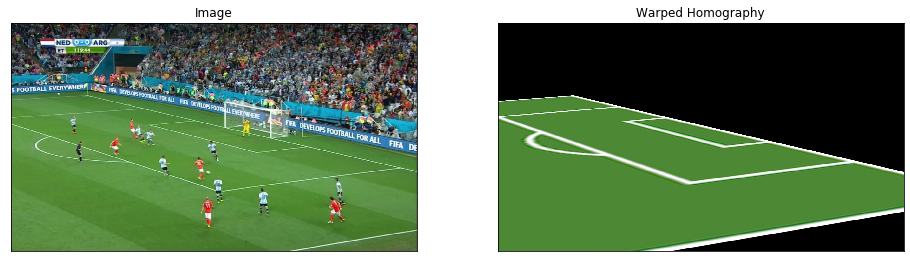

In [12]:
visualize(image=cv2.resize(image, (1280,720)),
         warped_homography = pred_warp)

# Keypoint Detector : 

In [13]:
full_model = KeypointDetectorModel(
    backbone='efficientnetb3', num_classes=29, input_shape=(320, 320),
)

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/keypoint_detector.h5"
)
RESNET_ARCHI_TF_KERAS_NAME = "keypoint_detector.h5"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/keypoint_detector.h5


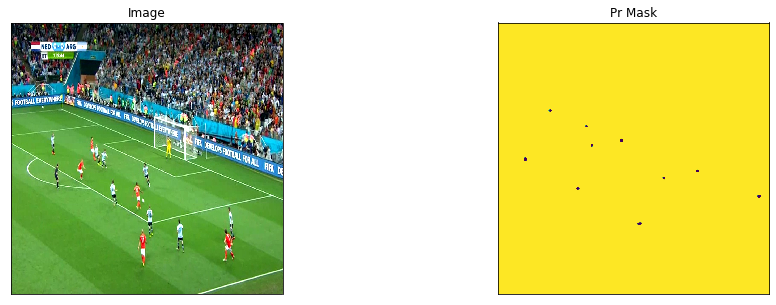

In [14]:
pr_mask = full_model(image)
visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., -1].squeeze(),
    )

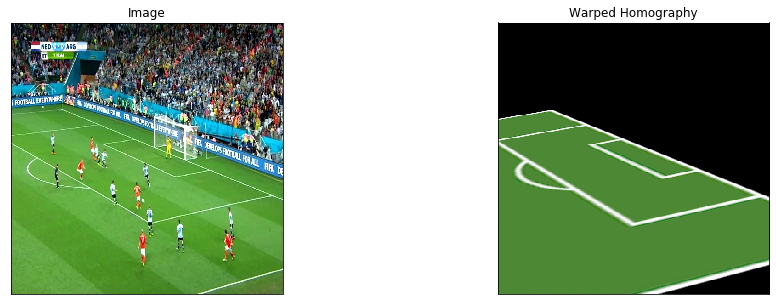

In [15]:
from narya.utils.masks import _points_from_mask 
from narya.utils.homography import get_perspective_transform
src,dst = _points_from_mask(pr_mask[0])
pred_homo = get_perspective_transform(dst,src)
pred_warp = warp_image(cv2.resize(template, (320,320)),pred_homo,out_shape=(320,320))
visualize(
        image=denormalize(image.squeeze()),
        warped_homography=pred_warp,
    )

# Player/Ball Tracker : 

In [16]:
full_model = TrackerModel(pretrained=True, backbone='ssd_512_resnet50_v1_coco')

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/player_tracker.params"
)
RESNET_ARCHI_TF_KERAS_NAME = "player_tracker.params"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/player_tracker.params


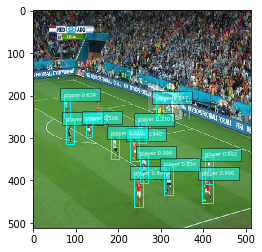

In [23]:
cid, score, bbox = full_model(image)
from gluoncv.utils import viz
ax = viz.plot_bbox(cv2.resize(image,(512,512)), bbox[0], score[0], cid[0], class_names=model.classes,thresh=0.5,linewidth=1,fontsize=5)
plt.show()

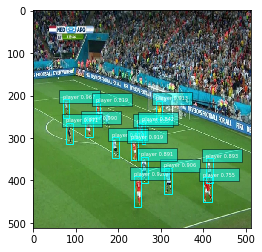

In [21]:
cid, score, bbox = full_model(image, split_size = 512)
from gluoncv.utils import viz
ax = viz.plot_bbox(cv2.resize(image,(512,512)), bbox[0], score[0], cid[0], class_names=model.classes,thresh=0.5,linewidth=1,fontsize=5)
plt.show()

In [24]:
bbox = bbox.asnumpy()
x_1 = int(bbox[0][0][0])
y_1 = int(bbox[0][0][1])
x_2 = int(bbox[0][0][2])
y_2 = int(bbox[0][0][3])
print(x_1,x_2,y_1,y_2)

237 258 387 462


# Player embedding extractor : 

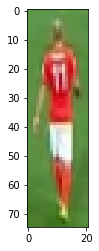

In [25]:
resized_image = cv2.resize(image,(512,512))
plt.imshow(resized_image[y_1:y_2,x_1:x_2])

In [26]:
full_model = ReIdModel()

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/player_reid.pth"
)
RESNET_ARCHI_TF_KERAS_NAME = "player_reid.pth"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/player_reid.pth


In [27]:
player_img = resized_image[y_1:y_2,x_1:x_2]
embedding = full_model(player_img)

In [28]:
embedding[0].shape

(751,)